# Importing the Libraries

In [1]:
import pandas as pd 
import numpy as np
import warnings
from scipy.stats import mode
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Loading the Dataset

In [2]:
train=pd.read_csv('Train.csv')
test=pd.read_csv('Test.csv')
new = test[['Item_Identifier', 'Outlet_Identifier']].copy()
new

,Item_Identifier,Outlet_Identifier
0,FDW58,OUT049
1,FDW14,OUT017
2,NCN55,OUT010
3,FDQ58,OUT017
4,FDY38,OUT027
...,...,...
5676,FDB58,OUT046
5677,FDD47,OUT018
5678,NCO17,OUT045
5679,FDJ26,OUT017


In [3]:

train['source'] = 'train'
test['source'] = 'test'

# combining the test and train datasets
data = pd.concat([train, test], ignore_index=True)
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  source                     14204 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usag

In [5]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# Data Preprocessing

In [6]:
# checking for the presence of null values
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

In [7]:
# replacing missing values
data['Item_Weight'] = data.groupby('Item_Identifier')['Item_Weight'].transform(
    lambda grp: grp.fillna(np.mean(grp)))
data['Item_Weight'].fillna((data['Item_Weight'].mean()), inplace = True)

data['Outlet_Size'] = data.groupby('Outlet_Type')['Outlet_Size'].transform(
    lambda group: group.fillna(mode(group).mode[0]))
# correcting visibilty of items having 0.0
data['Item_Visibility'] = data.groupby('Item_Identifier')['Item_Visibility'].transform(
    lambda grp: grp.replace(0,np.mean(grp)))
data.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

In [8]:
data["Item_Identifier"].value_counts()

FDY35    10
FDE34    10
NCK31    10
FDM44    10
FDT11    10
         ..
FDH58     7
NCL42     7
FDM52     7
FDO33     7
DRN11     7
Name: Item_Identifier, Length: 1559, dtype: int64

In [9]:
# changing item_identifier into a better understandable format
data['Item_Identifier'] = (data['Item_Identifier'].apply(lambda x: x[0:2])).map({'FD':'Food',
                                                             'NC':'Non_Consumable',
                                                             'DR':'Drinks'})
data["Item_Identifier"].value_counts()

Food              10201
Non_Consumable     2686
Drinks             1317
Name: Item_Identifier, dtype: int64

In [10]:
data["Item_Fat_Content"].value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

In [11]:
# changing the Item_Fat_Content values to the same format
data["Item_Fat_Content"]=data["Item_Fat_Content"].replace(['LF','low fat'],'Low Fat').replace('reg','Regular')
data.loc[data['Item_Identifier']=="Non_Consumable", 'Item_Fat_Content'] = 'Non-Edible'
data["Item_Fat_Content"].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

In [12]:
data["Item_Type"].value_counts()

Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

In [13]:
data["Outlet_Identifier"].value_counts()

OUT027    1559
OUT013    1553
OUT035    1550
OUT046    1550
OUT049    1550
OUT045    1548
OUT018    1546
OUT017    1543
OUT010     925
OUT019     880
Name: Outlet_Identifier, dtype: int64

In [14]:
data["Outlet_Size"].value_counts()

Small     7996
Medium    4655
High      1553
Name: Outlet_Size, dtype: int64

In [15]:
data["Outlet_Location_Type"].value_counts()

Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

In [16]:
data["Outlet_Type"].value_counts()

Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1559
Supermarket Type2    1546
Name: Outlet_Type, dtype: int64

In [17]:
# converting Outlet_Establishment_Year to Outlet_Age for better insights
now = datetime.datetime.now()
this_yr=now.year

data['Outlet_Age'] = this_yr - data['Outlet_Establishment_Year']
data = data.drop(['Outlet_Establishment_Year'], axis=1)
data['Outlet_Age'].value_counts().sort_values()


23     925
14    1543
12    1546
19    1548
22    1550
17    1550
24    1550
34    1553
36    2439
Name: Outlet_Age, dtype: int64

# Exploratory Data Analysis

In [18]:
plt.rcParams["figure.figsize"] = (12,7)

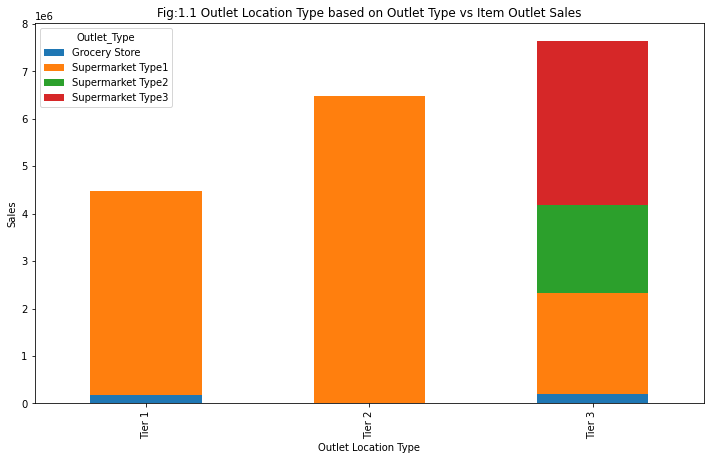

In [19]:
# plotting Outlet_Location_Type based on Outlet_Type vs Item_Outlet_Sales
data.pivot_table(index = 'Outlet_Location_Type',values = 'Item_Outlet_Sales',columns='Outlet_Type',aggfunc = np.sum).plot(kind='bar',stacked=True)
plt.xlabel("Outlet Location Type")
plt.ylabel("Sales")
plt.title("Fig:1.1 Outlet Location Type based on Outlet Type vs Item Outlet Sales")
plt.show()

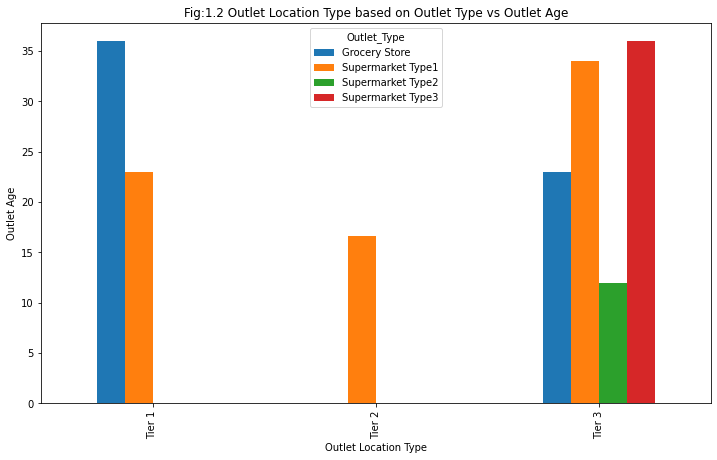

In [20]:
# plotting Outlet_Location_Type based on Outlet_Type vs Outlet_Age
data.pivot_table(index = 'Outlet_Location_Type',values = 'Outlet_Age',columns='Outlet_Type').plot(kind='bar')
plt.xlabel("Outlet Location Type")
plt.ylabel("Outlet Age")
plt.title("Fig:1.2 Outlet Location Type based on Outlet Type vs Outlet Age")
plt.show()

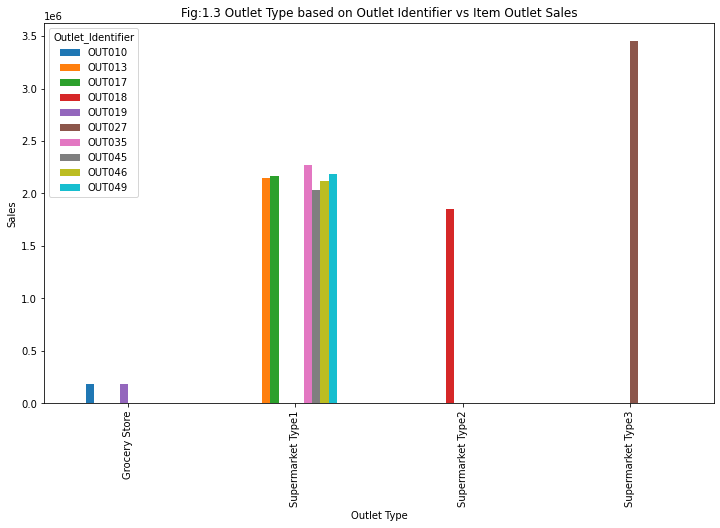

In [21]:
# plotting Outlet_Type based on Outlet_Identifier vs Item_Outlet_Sales
data.pivot_table(index = 'Outlet_Type',values = 'Item_Outlet_Sales',columns='Outlet_Identifier',aggfunc = np.sum).plot(kind='bar')
plt.xlabel("Outlet Type")
plt.ylabel("Sales")
plt.title("Fig:1.3 Outlet Type based on Outlet Identifier vs Item Outlet Sales")
plt.show()

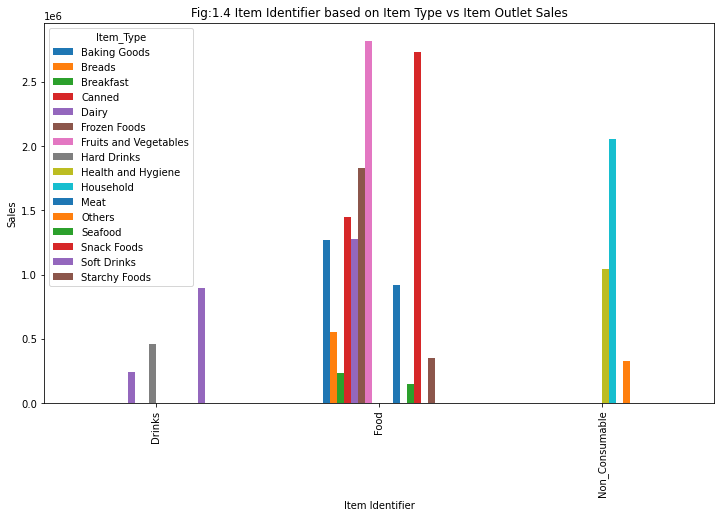

In [22]:
# plotting Item_Identifier based on Item_Type vs Item_Outlet_Sales
data.pivot_table(index = 'Item_Identifier',values = 'Item_Outlet_Sales',columns='Item_Type',aggfunc = np.sum).plot(kind='bar')
plt.xlabel("Item Identifier")
plt.ylabel("Sales")
plt.title("Fig:1.4 Item Identifier based on Item Type vs Item Outlet Sales")
plt.show()

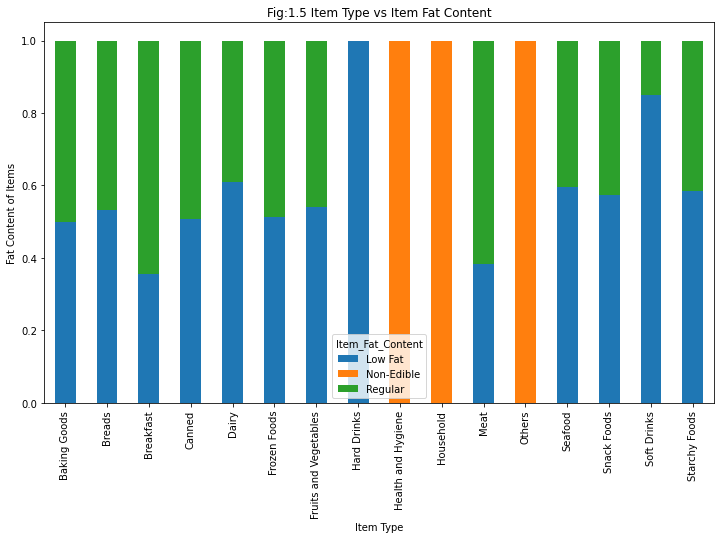

In [23]:
#plotting Item_Type vs Item_Fat_Content
graph= pd.crosstab(data['Item_Type'], data['Item_Fat_Content'])
graph.div(graph.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel("Item Type")
plt.ylabel("Fat Content of Items")
plt.title("Fig:1.5 Item Type vs Item Fat Content")
plt.show()

# Categorical Data Encoding and Feature Scaling

In [24]:
# encoding categorical data
data = pd.get_dummies(data, columns=['Item_Identifier','Item_Fat_Content', 'Item_Type',  'Outlet_Identifier', 
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],drop_first=True)
data.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,source,Outlet_Age,Item_Identifier_Food,Item_Identifier_Non_Consumable,Item_Fat_Content_Non-Edible,Item_Fat_Content_Regular,...,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0.016047,249.8092,3735.1380,train,22,1,0,0,0,...,0,0,1,1,0,0,0,1,0,0
1,5.92,0.019278,48.2692,443.4228,train,12,0,0,0,1,...,0,0,0,1,0,0,1,0,1,0
2,17.50,0.016760,141.6180,2097.2700,train,22,1,0,0,0,...,0,0,1,1,0,0,0,1,0,0
3,19.20,0.017834,182.0950,732.3800,train,23,1,0,0,1,...,0,0,0,0,1,0,1,0,0,0
4,8.93,0.009780,53.8614,994.7052,train,34,0,1,1,0,...,0,0,0,0,0,0,1,1,0,0


In [25]:
warnings.filterwarnings('ignore')

# Divide into test and train datasets
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

# Drop unnecessary columns
train.drop(['source'],axis=1,inplace=True)
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
trainX = train.drop(['Item_Outlet_Sales'], axis=1)
trainY = train.Item_Outlet_Sales

In [26]:
# creating a dataframe consisting of column names
xcol_names=list(trainX.columns)
xcol_names=pd.DataFrame(xcol_names,columns=['Independent Variables'])
xcol_names

,Independent Variables
0,Item_Weight
1,Item_Visibility
2,Item_MRP
3,Outlet_Age
4,Item_Identifier_Food
5,Item_Identifier_Non_Consumable
6,Item_Fat_Content_Non-Edible
7,Item_Fat_Content_Regular
8,Item_Type_Breads
9,Item_Type_Breakfast


In [27]:
# normalizing the variables
trainY = trainY.values.reshape(len(trainY),1)

sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(trainX)
y = sc_y.fit_transform(trainY)
testX = sc_X.fit_transform(test)

In [28]:
# creating dataframes of x and y datasets
X=pd.DataFrame(data=X)
y=pd.DataFrame(data=y)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,-0.769246,-1.081039,1.747454,-0.139541,0.625708,-0.480558,-0.480558,-0.738147,-0.174193,-0.114346,...,-0.349762,-0.349973,2.857362,1.432326,-1.134925,-0.696678,-0.804732,0.726802,-0.349551,-0.351028
1,-1.496813,-1.016230,-1.489023,-1.334103,-1.598190,-0.480558,-0.480558,1.354743,-0.174193,-0.114346,...,-0.349762,-0.349973,-0.349973,1.432326,-1.134925,-0.696678,1.242650,-1.375891,2.860816,-0.351028
2,0.995858,-1.066741,0.010040,-0.139541,0.625708,-0.480558,-0.480558,-0.738147,-0.174193,-0.114346,...,-0.349762,-0.349973,2.857362,1.432326,-1.134925,-0.696678,-0.804732,0.726802,-0.349551,-0.351028
3,1.361794,-1.045193,0.660050,-0.020085,0.625708,-0.480558,-0.480558,1.354743,-0.174193,-0.114346,...,-0.349762,-0.349973,-0.349973,-0.698165,0.881116,-0.696678,1.242650,-1.375891,-0.349551,-0.351028
4,-0.848890,-1.206757,-1.399220,1.293934,-1.598190,2.080915,2.080915,-0.738147,-0.174193,-0.114346,...,-0.349762,-0.349973,-0.349973,-0.698165,-1.134925,-0.696678,1.242650,0.726802,-0.349551,-0.351028


# Model Building 

In [29]:
# splitting the dataset into training and test set
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 101)

In [30]:
# linear regression model
reg = LinearRegression()
reg.fit(x_train,y_train)
y_pred=reg.predict(x_test)
y_pred

array([[-0.51620314],
       [ 0.13394335],
       [-0.45638868],
       ...,
       [-0.67367384],
       [-0.40292189],
       [ 0.14908007]])

In [31]:
# coefficients of linear regression model
reg.coef_

array([[ 4.32874257e-03, -1.02371038e-02,  5.72666117e-01,
         1.08921837e+13, -6.89782418e-03,  3.20093249e+11,
        -9.05264800e+11,  1.04025166e-02,  7.28437711e-03,
         1.24477303e-03,  4.49095946e-03, -1.08410869e-02,
        -4.59343429e-03,  7.12514618e-03, -7.55317880e-03,
         3.58763723e+11,  4.62891337e+11,  7.00070035e-03,
         2.08963787e+11,  7.48208528e-03,  5.81757822e-04,
        -8.70809131e-03,  6.83659484e-04, -8.89353588e+12,
         2.44227779e+12,  1.31517723e+12, -5.59779474e+12,
        -3.86331536e+12,  1.22987453e+12,  4.18324971e+11,
        -5.62147419e+12, -4.62071420e+12, -2.05124331e+12,
        -1.86636177e+12, -6.03481719e+12, -3.08018766e+12,
         4.95673557e+12,  3.33227416e+12, -1.23303543e+12]])

In [32]:
# creating a dataframe of linear regression model coefficients
coef_lin=pd.DataFrame(data=reg.coef_)
coef_lin=coef_lin.values.reshape(39,1)

In [33]:
# intercept of linear regression model
reg.intercept_

array([0.00753954])

In [34]:
# computing rmse and r square values linear regression model
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
r2=r2_score(y_test,y_pred)
print(rmse,r2)           

0.6434838618249028 0.55760305693897


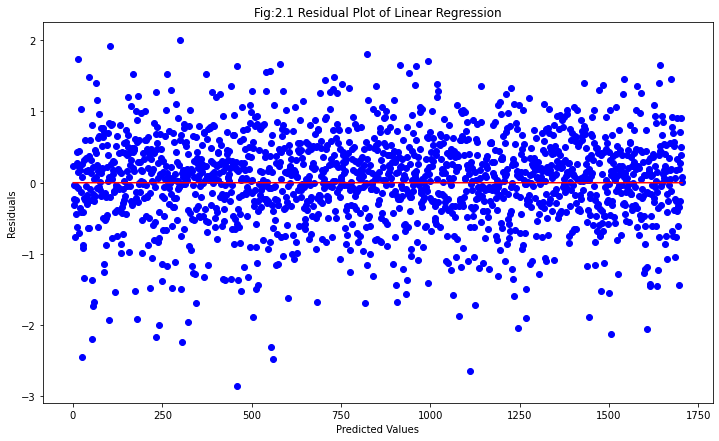

In [35]:
# residual plot linear regression model
x=[i for i in range(1,len(y_pred)+1)]
x_plot = plt.scatter(x,(y_pred-y_test),c='b')
plt.plot(x,[0]*len(y_pred),c='r')
plt.title("Fig:2.1 Residual Plot of Linear Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

In [36]:
# finding the best parameter(alpha)
def test(models, data):
    results = {}
    for i in models:
        r2 = []
        alpha = []
        r2.append(r2_score(y_test,models[i].fit(x_train,y_train).predict(x_test)))
        alpha.append(models[i].alpha)
        results[i] = [np.mean(r2), alpha]
    return pd.DataFrame(results)


In [37]:
params = {'alpha':[0.01,0.02,0.03,0.4,0.5,1,5,10,20,50]}

models2 = {'Ridge': GridSearchCV(Ridge(),param_grid=params).fit(x_train,y_train).best_estimator_,
           'Lasso': GridSearchCV(Lasso(),param_grid=params).fit(x_train,y_train).best_estimator_,}

In [38]:
test(models2, train)

,Ridge,Lasso
0,0.557773,0.557552
1,[20],[0.01]


In [60]:
# ridge regression model
ridgereg=Ridge(alpha=1)
ridgereg.fit(x_train,y_train)
pred1=ridgereg.predict(x_test)



In [101]:
# Fitting Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100,max_depth=6, min_samples_leaf=55,n_jobs=4)
regressor.fit(x_train, y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=55, n_jobs=4)

In [72]:
from sklearn.tree import DecisionTreeRegressor
df = DecisionTreeRegressor(max_depth=15,min_samples_leaf=100)
df.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)

In [40]:
# coefficients of ridge regression model
ridgereg.coef_

array([[ 4.72704116e-03, -1.02628097e-02,  5.71987077e-01,
         3.88432961e-02, -1.22011297e-02, -4.87849165e-03,
        -4.87849165e-03,  1.09354735e-02,  4.23340987e-03,
         2.71795022e-03,  6.30086137e-03, -8.28758367e-03,
         8.32730321e-05,  6.62644220e-03, -8.65792828e-03,
         1.22682494e-03, -5.81801338e-03,  5.85474930e-03,
        -2.87986169e-03,  7.67887482e-03, -2.73716471e-04,
        -1.15284176e-02,  8.68687203e-04,  8.30730173e-02,
         7.64509108e-02,  5.68745722e-02, -7.24820048e-02,
         1.98651843e-01,  7.72434555e-02,  3.45171448e-02,
         1.23849872e-01, -5.76413355e-02,  1.31721322e-01,
        -1.76911804e-01,  1.25005842e-01, -1.26531171e-01,
         2.21202589e-01,  5.68745722e-02,  1.98651843e-01]])

In [41]:
# creating a dataframe of ridge regression model coefficients
coef_ridge=pd.DataFrame(data=reg.coef_)
coef_ridge=coef_ridge.values.reshape(39,1)


In [42]:
# intercept of ridge regression model
ridgereg.intercept_

array([0.00688934])

In [43]:
# computing rmse and r square values of ridge regression model
rmse_1=np.sqrt(mean_squared_error(y_test,pred1))
r2_1=r2_score(y_test,pred1)
print(rmse,r2)

0.6434838618249028 0.55760305693897


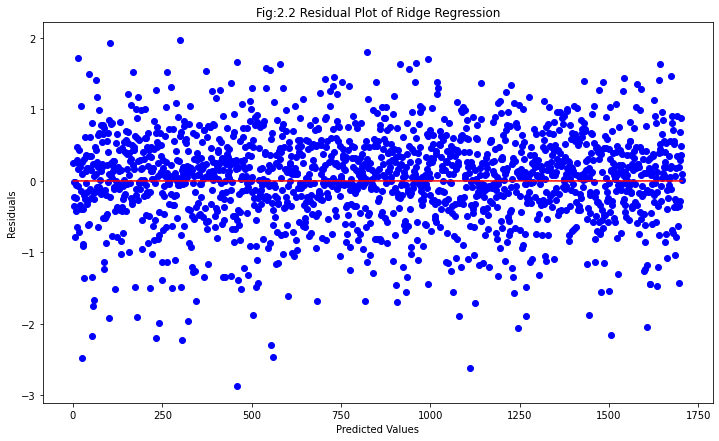

In [44]:
# residual plot f ridge regression model
x1=[i for i in range(1,len(pred1)+1)]
x1_plot = plt.scatter(x1,(pred1-y_test),c='b')
plt.plot(x1,[0]*len(pred1),c='r')
plt.title("Fig:2.2 Residual Plot of Ridge Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

In [45]:
# lasso regression
lassoreg=Lasso(alpha=0.01,normalize=False)
lassoreg.fit(x_train,y_train)
pred2=lassoreg.predict(x_test)
pred2

array([-0.51785302,  0.14092955, -0.52953115, ..., -0.55699239,
       -0.39105277,  0.14205858])

In [46]:
# coefficients of lasso regression model
lassoreg.coef_

array([ 0.        , -0.0089818 ,  0.56186052, -0.        ,  0.00302905,
       -0.        , -0.        ,  0.00362781,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.01826487,
        0.01534699, -0.01830989,  0.3065682 ,  0.02402092, -0.        ,
        0.        , -0.        ,  0.02348795, -0.01518104,  0.        ,
       -0.        ,  0.46305353,  0.20591802,  0.23395546])

In [47]:
# creating a dataframe of lasso regression model coefficients
coef_lasso=pd.DataFrame(data=reg.coef_)
coef_lasso=coef_lasso.values.reshape(39,1)

In [48]:
# intercept of lasso regression model
lassoreg.intercept_

array([0.0069])

In [49]:
# computing rmse and r square values of lasso regression model
rmse_2=np.sqrt(mean_squared_error(y_test,pred2))
r2_2=r2_score(y_test,pred2)
print(rmse_2,r2_2)

0.6435209587003292 0.5575520470587769


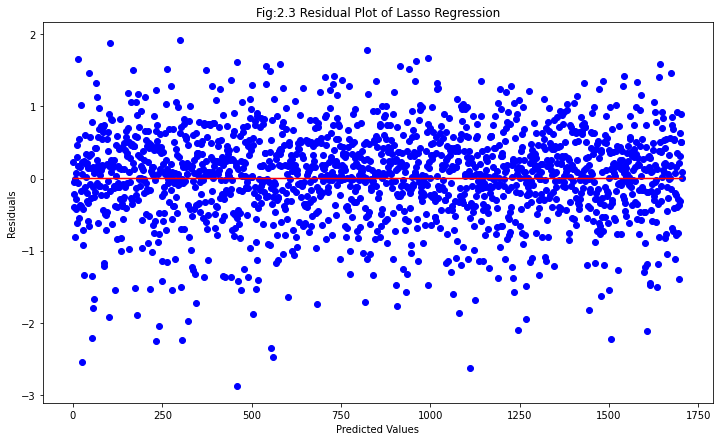

In [50]:
# residual plot of lasso regression model
pred2=pred2.reshape(len(pred2),1)
x2=[i for i in range(1,len(pred2)+1)]
x2_plot = plt.scatter(x2,(pred2-y_test),c='b')
plt.plot(x2,[0]*len(pred2),c='r')
plt.title("Fig:2.3 Residual Plot of Lasso Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

In [51]:
# creating a dataframe consisting of rmse and r square values
metrics_df=pd.DataFrame(columns=['metrics','Linear reg','Ridge reg','Lasso reg'])
metrics_df=metrics_df.append({'metrics':"RMSE ", 'Linear reg':rmse, 'Ridge reg':rmse_1, 'Lasso reg':rmse_2}, ignore_index=True)
metrics_df=metrics_df.append({'metrics': "R-SQUARE ", 'Linear reg':r2, 'Ridge reg':r2_1, 'Lasso reg':r2_2}, ignore_index=True)
metrics_df

,metrics,Linear reg,Ridge reg,Lasso reg
0,RMSE,0.643484,0.643422,0.643521
1,R-SQUARE,0.557603,0.557688,0.557552


# Finding Feature Importance

In [52]:
# creating a dataframe to display the feature's importance
feature_df=pd.DataFrame(columns=['Linear reg','Ridge reg','Lasso reg'])
for i in range(39):
    feature_df=feature_df.append({'Linear reg':coef_lin[i], 'Ridge reg':coef_ridge[i], 'Lasso reg':coef_lasso[i]}, ignore_index=True)
feature_df.sort_values('Lasso reg', axis=0, ascending=True, inplace=False, na_position='last').head()

data_join=feature_df.join(xcol_names, lsuffix="_left", rsuffix="_right").sort_values('Lasso reg', axis=0, ascending=False, inplace=False, na_position='last')
data_join

,Linear reg,Ridge reg,Lasso reg,Independent Variables
3,[10892183687904.814],[10892183687904.814],[10892183687904.814],Outlet_Age
36,[4956735573362.69],[4956735573362.69],[4956735573362.69],Outlet_Type_Supermarket Type1
37,[3332274163608.7793],[3332274163608.7793],[3332274163608.7793],Outlet_Type_Supermarket Type2
24,[2442277789972.307],[2442277789972.307],[2442277789972.307],Outlet_Identifier_OUT017
25,[1315177232847.3057],[1315177232847.3057],[1315177232847.3057],Outlet_Identifier_OUT018
28,[1229874529362.8804],[1229874529362.8804],[1229874529362.8804],Outlet_Identifier_OUT035
16,[462891337437.7993],[462891337437.7993],[462891337437.7993],Item_Type_Household
29,[418324971458.74927],[418324971458.74927],[418324971458.74927],Outlet_Identifier_OUT045
15,[358763723408.4121],[358763723408.4121],[358763723408.4121],Item_Type_Health and Hygiene
5,[320093249333.8883],[320093249333.8883],[320093249333.8883],Item_Identifier_Non_Consumable


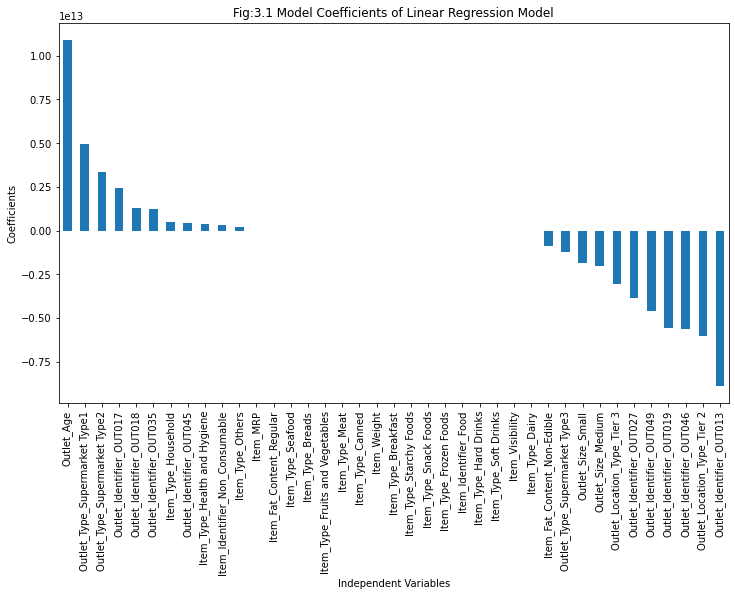

In [53]:
# plotting model coefficients of linear regression model
coef_graph =pd.Series(coef_lin.ravel(), trainX.columns).sort_values(ascending=False)
coef_graph.plot(kind='bar', title='Fig:3.1 Model Coefficients of Linear Regression Model')
plt.xlabel("Independent Variables")
plt.ylabel("Coefficients")
plt.show()

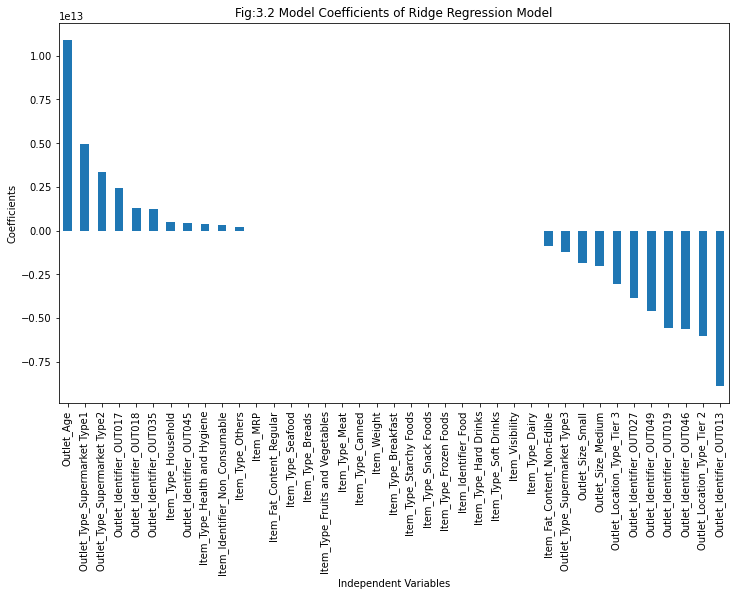

In [54]:
# plotting model coefficients of ridge regression model
coef_graph1 =pd.Series(coef_ridge.ravel(), trainX.columns).sort_values(ascending=False)
coef_graph1.plot(kind='bar', title='Fig:3.2 Model Coefficients of Ridge Regression Model')
plt.xlabel("Independent Variables")
plt.ylabel("Coefficients")
plt.show()

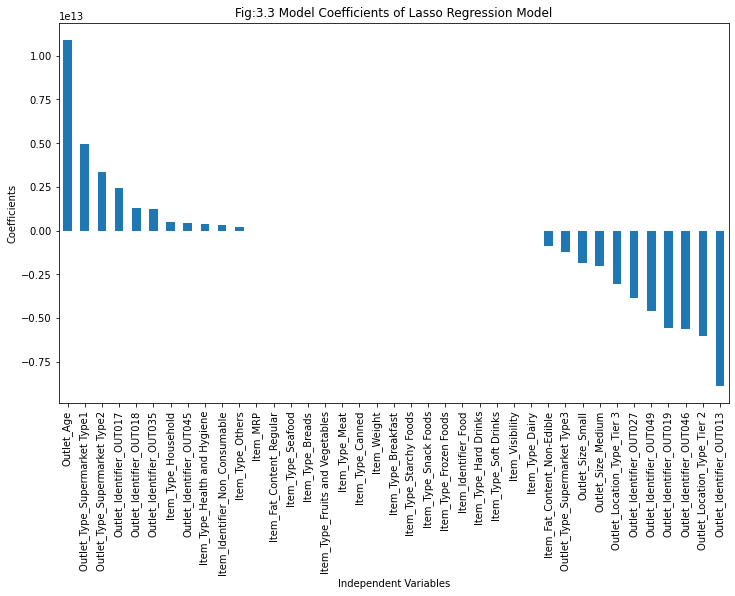

In [55]:
# plotting model coefficients of lasso regression model
coef_graph2 =pd.Series(coef_lasso.ravel(), trainX.columns).sort_values(ascending=False)
coef_graph2.plot(kind='bar', title='Fig:3.3 Model Coefficients of Lasso Regression Model')
plt.xlabel("Independent Variables")
plt.ylabel("Coefficients")
plt.show()

# Predicting Test Data

In [56]:
testX
X=pd.DataFrame(data=testX)
X

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,1.734064,-1.247634,-0.536555,-0.139891,0.627510,-0.486429,-0.486429,-0.740811,-0.172954,-0.116445,...,-0.349691,-0.350008,2.857079,1.432138,-1.134882,-0.696584,-0.804750,0.726900,-0.349374,-0.351274
1,-0.938845,-0.624550,-0.868937,-1.095512,0.627510,-0.486429,-0.486429,1.349873,-0.172954,-0.116445,...,-0.349691,-0.350008,-0.350008,-0.698257,0.881149,1.435578,-0.804750,0.726900,-0.349374,-0.351274
2,0.413711,0.609940,1.629848,-0.020438,-1.593601,2.055799,2.055799,-0.740811,-0.172954,-0.116445,...,-0.349691,-0.350008,-0.350008,-0.698257,0.881149,-0.696584,1.242623,-1.375706,-0.349374,-0.351274
3,-1.150316,-1.089686,0.226697,-1.095512,0.627510,-0.486429,-0.486429,-0.740811,-0.172954,-0.116445,...,-0.349691,-0.350008,-0.350008,-0.698257,0.881149,1.435578,-0.804750,0.726900,-0.349374,-0.351274
4,0.199020,0.994020,1.508110,1.532446,0.627510,-0.486429,-0.486429,1.349873,-0.172954,-0.116445,...,-0.349691,-0.350008,-0.350008,1.432138,-1.134882,-0.696584,1.242623,-1.375706,-0.349374,2.846782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5676,-0.466524,-1.127881,0.004727,0.099015,0.627510,-0.486429,-0.486429,1.349873,-0.172954,-0.116445,...,-0.349691,2.857079,-0.350008,-0.698257,0.881149,-0.696584,-0.804750,0.726900,-0.349374,-0.351274
5677,-1.089129,1.486457,0.455014,-1.334417,0.627510,-0.486429,-0.486429,1.349873,-0.172954,-0.116445,...,-0.349691,-0.350008,-0.350008,1.432138,-1.134882,-0.696584,1.242623,-1.375706,2.862264,-0.351274
5678,-0.573870,0.084095,-0.360485,-0.498248,-1.593601,2.055799,2.055799,-0.740811,-0.172954,-0.116445,...,2.859669,-0.350008,-0.350008,-0.698257,0.881149,1.435578,-0.804750,0.726900,-0.349374,-0.351274
5679,0.563996,0.383930,1.190844,-1.095512,0.627510,-0.486429,-0.486429,1.349873,-0.172954,-0.116445,...,-0.349691,-0.350008,-0.350008,-0.698257,0.881149,1.435578,-0.804750,0.726900,-0.349374,-0.351274


In [102]:
# fitting the best model on test dataset
pred_test=sc_y.inverse_transform(regressor.predict(testX))
pred=pred_test.reshape(len(pred_test),1)
pred
new1 = pd.DataFrame(pred, columns = ['Item_Outlet_Sales'])
data1 = [new['Item_Identifier'],new['Outlet_Identifier'], new1["Item_Outlet_Sales"]]

headers = ['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']

df = pd.concat(data1, axis=1, keys=headers)
df

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1713.796216
1,FDW14,OUT017,1392.991755
2,NCN55,OUT010,642.010795
3,FDQ58,OUT017,2528.171328
4,FDY38,OUT027,6154.178457
...,...,...,...
5676,FDB58,OUT046,2197.206025
5677,FDD47,OUT018,2425.820622
5678,NCO17,OUT045,1888.844117
5679,FDJ26,OUT017,3750.936301


In [103]:
df['Item_Outlet_Sales']=abs(df['Item_Outlet_Sales'])

In [104]:
df.to_csv('filerf3.csv')